In [1]:
import random
import scipy
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import minimize
from user_distributions import oneFarOneClose, leftSkewedNormal, leftUpSkewedNormal, leftUpRectangles

# Seed random number generators
seed = 324
random.seed(seed)
np.random.seed(seed)
rng = np.random.default_rng(seed)

## Parameters
Constant parameters used for the simulation

In [2]:
r_min = 1000 # meters
r_max = 5000 # meters
D = 10000 # meters
rD = 2000 # meters
cx_min = -20000 # meters
cx_max = 20000 # meters
cy_min = -20000
cy_max = 20000
v = 50 # meters/second
T = (2*np.pi*r_max)/v # seconds
TC = 1 # seconds
N = int(T // TC) # time slots
M = 2 # users
K = N*M # users served in one rotation
K_tot = K * 100 # total number of users in the deadzone
H = 100 # meters
PAtx = 1 # watts
PUtx = 0.07 # watts
GT = 1
GR = 1
B = 1e6 # Hz
N0 = 10**((7.5-174+10*np.log10(B))/10)/1000 # watts
F = 2e9 # Hz
WAVELENGTH = scipy.constants.c / F # meters

## Random user schedule
Create a random user schedule for one rotation

In [3]:
idxs = np.arange(K_tot)
np.random.shuffle(idxs)
idxs = idxs[:K]

random_schedule = np.reshape(idxs, (N, M))

## Constants for convenience
- `thetas` = UAV angle at each timeslot
- `cos_th` = $\cos(\text{UAV angle at each timeslot})$
- `sin_th` = $\sin(\text{UAV angle at each timeslot})$
- `CU` = $P^\text{U}_\text{tx} G_\text{T} G_\text{R} \left(\frac{\lambda}{4\pi}\right)^2$
- `CA` = $P^\text{A}_\text{tx} G_\text{T} G_\text{R} \left(\frac{\lambda}{4\pi}\right)^2$
- `AU` = $\frac{C_\text{U}M}{N_0}$
- `AB` = $\frac{C_\text{A}}{N_0}$ 

In [4]:
thetas = 2*np.pi*np.arange(N)/N
cos_th = np.cos(thetas)
sin_th = np.sin(thetas)
CU = PUtx*GT*GR*(WAVELENGTH/(4*np.pi))**2
CA = PAtx*GT*GR*(WAVELENGTH/(4*np.pi))**2
AU = (CU * M) / N0
AB = CA / N0

## User Generation
Here we define a function to randomly generate users within the deadzone. For the purposes of the simulation, we generate the maximum number of users. Smaller flight paths may not serve every user in one rotation, but the objective is normalized over timeslots. We plot the users at the end to verify that the distribution is correct.

len(users): 125600
K: 1256


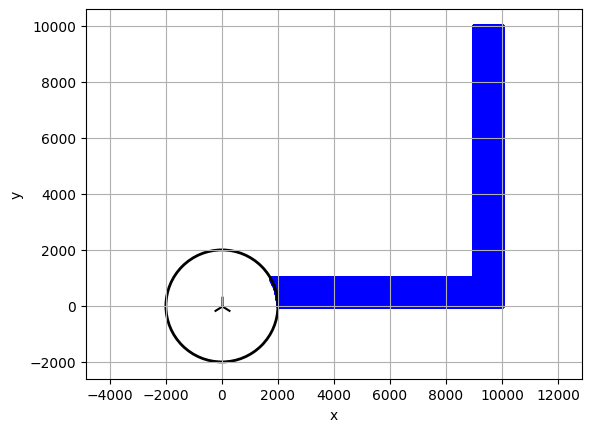

In [11]:
users = leftUpRectangles(K_tot, 10000, 1000, D, 0, seed=seed)
print(f'len(users): {len(users)}')
print(f'K: {K}')

xs, ys = zip(*users)
plt.scatter(xs, ys, c='b', marker='o', s=5)
plt.scatter(0, 0, c='black', marker='2', s=200, label="Origin")
ax = plt.gca()  # get current axes
circle = patches.Circle((0, 0), radius=2000, fill=False, color='black', linewidth=2)
ax.add_patch(circle)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-10000, 10000)
plt.ylim(-10000, 10000)
plt.axis("equal")  # equal scaling
plt.show()

## Mean SE (objective function)
The average achievable spectral efficiency of the relay system over the timeslots is given as
$$\overline{\text{SE}}(\alpha, r, \mathbf{c}) = \frac{1}{N}\sum_{n=1}^N \min\left[\alpha \cdot \frac{1}{M}\sum_{k\in\mathcal{U}_n}\text{SE}^\text{UA}_{n,k}\;\mathbf{,}\;(1-\alpha)\cdot\text{SE}^\text{AB}_n\right]$$

In [7]:
def meanSE(alpha, r, cx, cy, users, schedule):
    # Compute UAV position at each timeslot
    ax = cx + r*cos_th
    ay = cy + r*sin_th

    # Compute squared distances
    snk0 = []
    for n in range(N):
        idxs = np.asarray(schedule[n], dtype=int)
        dx = ax[n] - users[idxs, 0]
        dy = ay[n] - users[idxs, 1]
        snk0.append(dx*dx + dy*dy + H*H)
    sbn0 = (ax*ax + ay*ay + H*H)

    # Calculate SEUA and SEAB
    seua = []
    for n in range(N):
        seua.append( alpha * np.mean(np.log2(1.0 + AU/snk0[n])) )
    seab = (1-alpha)*np.log2(1.0 + AB/sbn0)

    # Calculate the mins
    min_se = [min(ua, ab) for ua, ab in zip(seua, seab)]

    # Return the average
    return np.mean(min_se)

## $\alpha$ Optimizer
Here I will define an optimizer to find the optimal $\alpha$ for a fixed $r$, $\mathbf{c}$.

In [9]:
def optimize_alpha(r, cx, cy, users, schedule, verbose=False):
    # Compute UAV position at each timeslot
    ax = cx + r*cos_th
    ay = cy + r*sin_th

    # Compute squared distances
    snk0 = []
    for n in range(N):
        idxs = np.asarray(schedule[n], dtype=int)
        dx = ax[n] - users[idxs, 0]
        dy = ay[n] - users[idxs, 1]
        snk0.append(dx*dx + dy*dy + H*H)
    sbn0 = (ax*ax + ay*ay + H*H)

    # Compute an and bn
    an = []
    for n in range(N):
        an.append(np.sum(np.log2(1.0 + AU/snk0[n])))
    bn = np.log2(1.0 + AB/sbn0)

    alpha_var = cp.Variable()
    tn_var = cp.Variable(N)
    cons = []

    for n in range(N):
        cons += [ tn_var[n] <= (alpha_var / M) * an[n] ]
        cons += [ tn_var[n] <= (1 - alpha_var) * bn[n] ]

    cons += [alpha_var >= 0, alpha_var <= 1]

    obj = cp.Maximize( cp.mean(tn_var) )

    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.MOSEK, verbose=verbose)

    if prob.status not in ("optimal", "optimal_inaccurate"):
        raise RuntimeError(f"SCA subproblem infeasible/failed: status {prob.status}")
    
    return float(alpha_var.value)

## Powell's optimizer for $\alpha$, $r$, $\mathbf{c}$
Here I define a block optimizer to iteratively optimize $\alpha$, $r$, $\mathbf{c}$.

Powell's Optimizer Iteration 0
    result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 1
    result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 2
    result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 3
    result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 4
    result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 5
    result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 6
    result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 7
    result.message: Optimization terminated successfully.

Optimal alpha: 0.558028183968557
Optimal radius: 1000.000487879071
Optimal center point: (5215.928302023096, 1427.713570792391)
Achievable SE: 3.0828343182029965


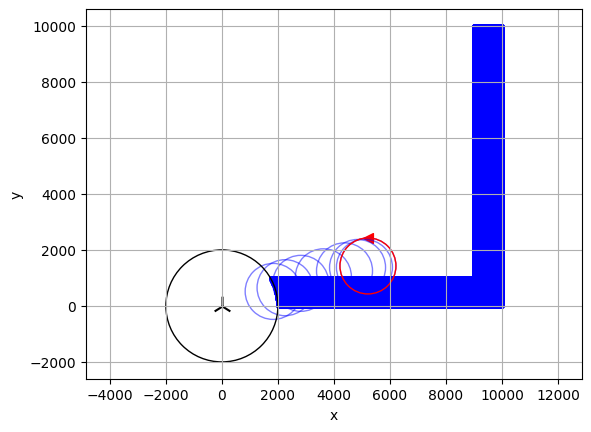

In [12]:
def objective(params, alpha, users, schedule):
    r, cx, cy = params
    return -meanSE(alpha, r, cx, cy, users, schedule)

def powells_optimizer(
                    alpha0, 
                    r0, 
                    cx0, 
                    cy0, 
                    rbounds,
                    cxbounds,
                    cybounds,
                    users,
                    schedule,
                    tolerance=1e-3
):
    # Initialize values
    alpha = alpha0
    r = r0
    cx = cx0
    cy = cy0
    bounds = [rbounds, cxbounds, cybounds]

    traj_history = []
    obj_history = []

    it = 0
    while True:
        print(f'Powell\'s Optimizer Iteration {it}')

        alpha = optimize_alpha(r, cx, cy, users, schedule)

        result = minimize(
                    objective,
                    [r,cx,cy],
                    args=(alpha, users, schedule),
                    method='Powell',
                    bounds=bounds,
                    options={
                        'maxiter':1000,
                        'xtol':1e-3,
                        'ftol':1e-3
                    }
        )
        print(f'    result.message: {result.message}')
        print()

        r, cx, cy = result.x

        obj_history.append(meanSE(alpha, r, cx, cy, users, schedule))
        traj_history.append((r, cx, cy))

        if it > 0:
            if ( (obj_history[-1] - obj_history[-2])/obj_history[-2] < tolerance):
                break
        it += 1
    
    return alpha, traj_history
        
alpha0 = 0.5
r0 = (r_min + r_max) / 2
cx0 = (cx_min + cx_max) / 2
cy0 = (cy_min + cy_max) / 2

alpha_opt, traj_hist = powells_optimizer(
                            alpha0, 
                            r0, 
                            cx0, 
                            cy0, 
                            (r_min, r_max),
                            (cx_min, cx_max),
                            (cy_min, cy_max),
                            users,
                            random_schedule)
r_opt, cx_opt, cy_opt = traj_hist[-1]
print(f'Optimal alpha: {alpha_opt}')
print(f'Optimal radius: {r_opt}')
print(f'Optimal center point: ({cx_opt}, {cy_opt})')
print(f'Achievable SE: {meanSE(alpha_opt, r_opt, cx_opt, cy_opt, users, random_schedule)}')

xs, ys = zip(*users)
plt.scatter(xs, ys, c='b', marker='o', s=5)
plt.scatter(0, 0, c='black', marker='2', s=200, label="Origin")
plt.scatter(cx_opt, cy_opt+r_opt, c='r', marker='<', s=50, label="UAV")
ax = plt.gca()  # get current axes
coverage_zone = patches.Circle((0, 0), radius=2000, fill=False, color='black', linewidth=1)
flight_path = patches.Circle((cx_opt, cy_opt), radius=r_opt, fill=False, color='red', linewidth=1)

for traj in traj_hist:
    r, cx, cy = traj
    path = patches.Circle((cx, cy), radius=r, fill=False, color='blue', alpha=0.5, linewidth=1)
    ax.add_patch(path)

ax.add_patch(coverage_zone)
ax.add_patch(flight_path)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-10000, 10000)
plt.ylim(-10000, 10000)
plt.axis("equal")  # equal scaling
plt.show()


## Successive convex approximation

SCA Optimizer Iteration 0
    MOSEK Iteration 0
    MOSEK Iteration 1
    MOSEK Iteration 2
    MOSEK Iteration 3
    MOSEK Iteration 4
    MOSEK Iteration 5
    MOSEK Iteration 6
    MOSEK Iteration 7
    MOSEK Iteration 8
    MOSEK Iteration 9
    MOSEK Iteration 10
    MOSEK Iteration 11
    MOSEK Iteration 12
    MOSEK Iteration 13
    MOSEK Iteration 14
SCA Iteration 0 results:
alpha = 0.5242439264543356, radius = 1000.0001053306382, center = (6620.5033050156535, 1437.951070398839)

SCA Optimizer Iteration 1
    MOSEK Iteration 0
    MOSEK Iteration 1
SCA Iteration 1 results:
alpha = 0.5294006557038136, radius = 1000.0000233606553, center = (6417.975869126899, 1655.2795057964681)

SCA Optimizer Iteration 2
    MOSEK Iteration 0
    MOSEK Iteration 1
SCA Iteration 2 results:
alpha = 0.5326934045752791, radius = 1000.0000011327265, center = (6292.690587043788, 1696.354037565055)

Optimal alpha: 0.5326934045752791
Optimal radius: 1000.0000011327265
Optimal center point: (6292.6905870

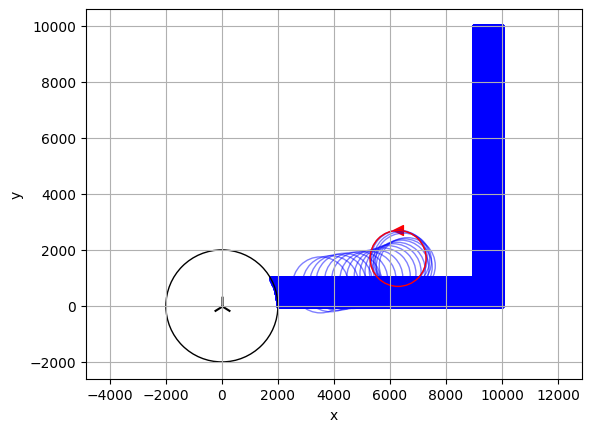

In [13]:
def sca_optimizer(alpha0, 
                r0, 
                cx0, 
                cy0,
                r_bounds, 
                cx_bounds, 
                cy_bounds,
                users,
                schedule,
                sca_tol=1e-3,
                max_sca_iters=30,
                overall_tol=1e-3,
                verbose=False,
):
    
    alpha = alpha0
    r = r0
    cx = cx0
    cy = cy0

    def f_and_grad(s, A):
        """Return f(s)=log2(1+A/s) and f'(s) = -A/(ln2*s*(s+A)) elementwise."""
        s = np.asarray(s, dtype=float)
        f = 1e4 * np.log2(1.0 + A/np.maximum(s,1e-9))
        fp = 1e4 * -(A) / (np.log(2.0) * np.maximum(s,1e-9) * (np.maximum(s,1e-9) + A))
        return f, fp
    
    traj_hist = []
    overall_obj_hist = []
    overall_it = 0
    while True:
        print(f'SCA Optimizer Iteration {overall_it}')

        sca_obj_hist = []
        sca_it = 0

        # r, c optimization
        for sca_it in range(max_sca_iters):
            print(f'    MOSEK Iteration {sca_it}')

            # Compute UAV coords
            ax = cx + r*cos_th
            ay = cy + r*sin_th

            # Compute squared distances
            snk0 = []
            for n in range(N):
                idxs = np.asarray(schedule[n], dtype=int)
                dx = ax[n] - users[idxs, 0]
                dy = ay[n] - users[idxs, 1]
                snk0.append(dx*dx + dy*dy + H*H)
            sbn0 = (ax*ax + ay*ay + H*H)            

            # Evaluate f and gradients at current s
            fU0 = []
            gU0 = []
            for n in range(N):
                fu, gu = f_and_grad(snk0[n], AU)
                fU0.append(fu)
                gU0.append(gu )
            fB0, gB0 = f_and_grad(sbn0, AB)

            # CVXPY variables
            r_var  = cp.Variable()
            cx_var = cp.Variable()
            cy_var = cp.Variable()
            t = cp.Variable(N)  # timeslot min-SE terms

            # Auxiliary upper-bounds for squared distances
            s_vars = cp.Variable((N,M))  # s_{n,k}
            sb_var = cp.Variable(N)  # b^2_n

            cons = []

            # Geometric "upper-bound" constraints: s >= true squared distance
            for n in range(N):
                # planar expressions are affine in (r,cx,cy)
                ax_n = cx_var + r_var*cos_th[n]
                ay_n = cy_var + r_var*sin_th[n]

                # user distances
                idxs = np.asarray(schedule[n], dtype=int)
                xk = users[idxs,0]
                yk = users[idxs,1]

                # ||(ax_n - xk, ay_n - yk)||^2 + H^2  <=  s_vars[n]  (as lower-bound on SE we want s_vars >= true)
                # Implement via rotated quadratic cone: s >= (ax_n - x)^2 + (ay_n - y)^2 + H^2
                # In cvxpy, simple convex way is: s >= (ax_n - x)^2 + (ay_n - y)^2 + H^2
                cons += [ s_vars[n] >= (ax_n - xk)**2 + (ay_n - yk)**2 + (H**2) ]

                # AB link
                cons += [ sb_var[n] >= (ax_n)**2 + (ay_n)**2 + (H**2) ]
            
            # Linearized (conservative) SE constraints per slot:
            # t_n <= (alpha/M) sum_k [ fU0 + gU0 * (s - s0) ]
            # t_n <= (1-alpha)      [ fB0 + gB0 * (sb - sb0) ]
            for n in range(N):
                # UA side
                f0 = fU0[n]         # shape (M,)
                g0 = gU0[n]         # shape (M,)
                s0 = snk0[n]       # shape (M,)

                # UA side
                cons += [
                    t[n] <= (alpha/M) * ( cp.sum(f0) + g0 @ (s_vars[n] - s0) )
                ]

                # AB side
                cons += [
                    t[n] <= (1.0 - alpha) * ( fB0[n] + gB0[n] * (sb_var[n] - sbn0[n]) )
                ]
            
            # Add parameter bounds
            r_min, r_max = r_bounds
            cons += [ r_var >= r_min, r_var <= r_max ]
            
            cx_min, cx_max = cx_bounds
            cons += [ cx_var >= cx_min, cx_var <= cx_max ]
            
            cy_min, cy_max = cy_bounds
            cons += [ cy_var >= cy_min, cy_var <= cy_max ]

            # Solve objective
            obj = cp.Maximize( cp.mean(t) )
            prob = cp.Problem(obj, cons)
            prob.solve(solver=cp.MOSEK, verbose=verbose)

            if prob.status not in ("optimal", "optimal_inaccurate"):
                raise RuntimeError(f"    SCA subproblem infeasible/failed at iter {sca_it}: status {prob.status}")
            
            # Update iterate
            r = float(r_var.value)
            cx = float(cx_var.value)
            cy = float(cy_var.value)

            traj_hist.append((r, cx, cy))
            sca_obj_hist.append(float(np.sum(t.value)/N))

            if sca_it > 0:
                # Convergence check (relative improvement in objective)
                if (sca_obj_hist[-1] - sca_obj_hist[-2])/max(1e-9, abs(sca_obj_hist[-2])) < sca_tol:
                    break
        
        # alpha optimization
        alpha = optimize_alpha(r, cx, cy, users, schedule)

        # Print iteration results
        print(f'SCA Iteration {overall_it} results:')
        print(f'alpha = {alpha}, radius = {r}, center = ({cx}, {cy})')
        print()
        
        # Check for convergence
        overall_obj_hist.append(meanSE(alpha, r, cx, cy, users, schedule))
        if overall_it > 0:
            if (overall_obj_hist[-1] - overall_obj_hist[-2])/max(1e-9, abs(overall_obj_hist[-2])) < overall_tol:
                break
        
        overall_it += 1
    
    return alpha, traj_hist

alpha0 = 0.5
r0 = (r_min + r_max) / 2
cx0 = (cx_min + cx_max) / 2
cy0 = (cy_min + cy_max) / 2

alpha_opt, traj_hist = sca_optimizer(
                                    alpha0,
                                    r0,
                                    cx0,
                                    cy0,
                                    (r_min, r_max),
                                    (cx_min, cx_max),
                                    (cy_min, cy_max),
                                    users,
                                    random_schedule,
                                    verbose=False
)

r_opt, cx_opt, cy_opt = traj_hist[-1]

print(f'Optimal alpha: {alpha_opt}')
print(f'Optimal radius: {r_opt}')
print(f'Optimal center point: ({cx_opt}, {cy_opt})')
print(f'Achievable SE: {meanSE(alpha_opt, r_opt, cx_opt, cy_opt, users, random_schedule)}')

xs, ys = zip(*users)
plt.scatter(xs, ys, c='b', marker='o', s=5)
plt.scatter(0, 0, c='black', marker='2', s=200, label="Origin")
plt.scatter(cx_opt, cy_opt+r_opt, c='r', marker='<', s=50, label="UAV")
ax = plt.gca()  # get current axes
coverage_zone = patches.Circle((0, 0), radius=2000, fill=False, color='black', linewidth=1)
flight_path = patches.Circle((cx_opt, cy_opt), radius=r_opt, fill=False, color='red', linewidth=1)

for traj in traj_hist:
    r, cx, cy = traj
    path = patches.Circle((cx, cy), radius=r, fill=False, color='blue', alpha=0.5, linewidth=1)
    ax.add_patch(path)

ax.add_patch(coverage_zone)
ax.add_patch(flight_path)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-10000, 10000)
plt.ylim(-10000, 10000)
plt.axis("equal")  # equal scaling
plt.show()

## CDF data
Here I define a function which generates CDF data for a given $\alpha$, $r$, $\mathbf{c}$

In [54]:
def cdf_data(alpha, r, cx, cy, users, schedule):
    # Compute UAV position at each timeslot
    ax = cx + r*cos_th
    ay = cy + r*sin_th

    # Compute squared distances
    snk0 = []
    for n in range(N):
        idxs = np.asarray(schedule[n], dtype=int)
        dx = ax[n] - users[idxs, 0]
        dy = ay[n] - users[idxs, 1]
        snk0.append(dx*dx + dy*dy + H*H)
    sbn0 = (ax*ax + ay*ay + H*H)

    # Compute spectral efficiencies
    seua = []
    for n in range(N):
        seua.append(alpha * np.log2(1.0 + AU/snk0[n]))
    seab = (1 - alpha) * np.log2(1.0 + AB/sbn0)

    # Compute SE achieved per user
    per_user = [ [] for k in range(K_tot) ]
    for n in range(N):
        idxs = np.asarray(schedule[n], dtype=int)

        # Average spectral efficiency over all the users
        timeslot_seua = np.mean(seua[n])

        # UAV-BS spectral efficiency
        timeslot_seab = seab[n]

        # If user-UAV SE < UAV-BS SE, each user keeps their SE
        if (timeslot_seua < timeslot_seab):
            col = np.array(seua[n])
        
        # Otherwise, user SEs are scaled by (UAV-BS SE)/(user-UAV SE)
        else:
            ratio = timeslot_seab / timeslot_seua
            col = np.array(seua[n]*ratio)
        
        # Append values to the right users
        for i, idx in enumerate(idxs):
            per_user[idx].append(col[i])
            
    return per_user

# CDF plot

Monte Carlo Iteration 0
Powell's Optimizer Iteration 0
    result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 1
    result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 2
    result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 3
    result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 4
    result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 5
    result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 6
    result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 7
    result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 8
    result.message: Optimization terminated successfully.

Monte Carlo Iteration 1
Powell's Optimizer Iteration 0
    result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 1
    result.message: O

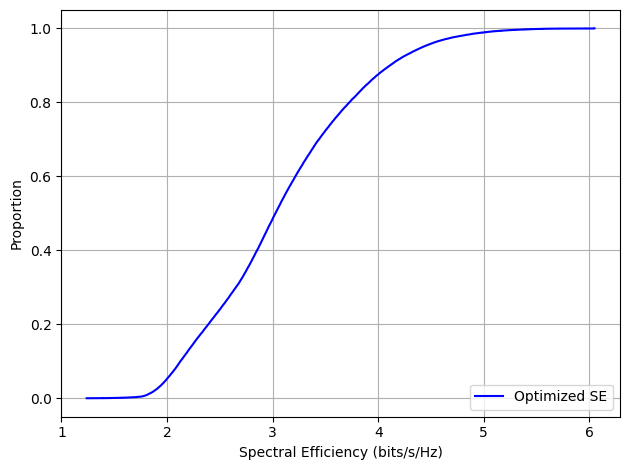

In [58]:
alpha0 = 0.5
r0 = (r_min + r_max) / 2
cx0 = (cx_min + cx_max) / 2
cy0 = (cy_min + cy_max) / 2

per_user = [ [] for i in range(K_tot) ]
for it in range(100):
    print(f"Monte Carlo Iteration {it}")
    idxs = np.arange(K_tot)
    np.random.shuffle(idxs)
    idxs = idxs[:K]
    random_schedule = np.reshape(idxs, (N, M))

    alpha_opt, traj_hist = powells_optimizer(
                            alpha0, 
                            r0, 
                            cx0, 
                            cy0, 
                            (r_min, r_max),
                            (cx_min, cx_max),
                            (cy_min, cy_max),
                            users,
                            random_schedule)
    r_opt, cx_opt, cy_opt = traj_hist[-1]

    iteration_dat = cdf_data(alpha_opt, r_opt, cx_opt, cy_opt, users, random_schedule)

    for i, arr in enumerate(iteration_dat):
        per_user[i] += arr

trimmed = [data for data in per_user if data != []]

means = [np.mean(user) for user in trimmed]
means = np.sort(means)

cdf = np.arange(1, len(means)+1) / len(means)

plt.plot(means, cdf, drawstyle="steps-post", label='Optimized SE', c='b')
plt.xlabel('Spectral Efficiency (bits/s/Hz)')
plt.ylabel('Proportion')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()    

## Variance vs. gain over baselines

In [153]:
def variance_gain():
    variances =  np.arange(2000, 8000, 50)

    alpha0 = 0.5
    r0 = (r_min + r_max)/2
    cx0 = D/2
    cy0 = 0

    optimized = []
    centered = []
    upper_bound = []

    for variance in variances:
        print(f'Variance: {variance}')
        users = np.asarray(leftUpSkewedNormal(K, D, variance, D, variance, seed=seed))

        centered.append(meanSE(
                        alpha0,
                        r_min,
                        cx0,
                        cy0,
                        users))
        
        alpha_opt, traj_hist = powells_optimizer(alpha0,
                                                 r0,
                                                 cx0,
                                                 cy0,
                                                 (r_min, r_max),
                                                 (cx_min, cx_max),
                                                 (cy_min, cy_max),
                                                 users)
        r_opt, cx_opt, cy_opt = traj_hist[-1]

        optimized.append(meanSE(alpha_opt,
                        r_opt,
                        cx_opt,
                        cy_opt,
                        users))
        
        upper_total = 0
        for user in users:
            xk, yk = user
            alpha, cx, cy = single_user_rotary_wing(xk/2, yk/2, xk, yk)
            upper_total += individual_se(alpha, cx, cy, xk, yk)
        
        upper_bound.append(upper_total / K)
        
        
    plt.scatter(variances, optimized, c='g', marker='>', s=5, label='optimized-trajectory')
    plt.scatter(variances, centered, c='r', marker='>', s=5, label='centered-trajectory')
    plt.scatter(variances, upper_bound, c='b', marker='>', s=5, label='upper-bound')
    plt.grid(True)
    plt.xlabel("Variance")
    plt.ylabel("Optimized Spectral Efficiency Gain")
    plt.legend()
    plt.show()        

variance_gain()

Variance: 2000
Iteration 0
Optimization terminated successfully.
Iteration 1
Optimization terminated successfully.
Iteration 2
Optimization terminated successfully.
Iteration 3
Optimization terminated successfully.
Iteration 4
Optimization terminated successfully.
Iteration 5
Optimization terminated successfully.
Iteration 6
Optimization terminated successfully.
Iteration 7
Optimization terminated successfully.
Iteration 8
Optimization terminated successfully.
Iteration 9
Optimization terminated successfully.
Variance: 2050
Iteration 0
Optimization terminated successfully.
Iteration 1
Optimization terminated successfully.
Iteration 2
Optimization terminated successfully.
Iteration 3
Optimization terminated successfully.
Iteration 4
Optimization terminated successfully.
Iteration 5
Optimization terminated successfully.
Iteration 6
Optimization terminated successfully.
Iteration 7
Optimization terminated successfully.
Iteration 8
Optimization terminated successfully.
Iteration 9
Optimiza

KeyboardInterrupt: 